## Install required packages

In [4]:
pip install gensim matplotlib scikit-learn ipykernel sentencepiece


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import sys
import time
import re
import sentencepiece as spm
import numpy as np
import pandas as pd
import gensim
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
print("ROOT_DIR =", ROOT_DIR)  # should be .../dsa4213
sys.path.append(ROOT_DIR)

# set file paths and import necessary things
w2v_model_path = os.path.join(ROOT_DIR, "Features", "encoding", "bilstm_pipeline", "embedder_files", "word2vec.model")
sp_model_path  = os.path.join(ROOT_DIR, "Features", "encoding", "bilstm_pipeline", "embedder_files", "email_sp.model")                              

ROOT_DIR = /Users/subhashree/Desktop/dsa4213


## Full Batch 

### Load & inspect word embeddings

In [7]:
# load the full Word2Vec model
w2v_model = Word2Vec.load(w2v_model_path)
print("Word2Vec Model loaded successfully.")

# load SentencePiece model as sp (SentencePieceProcessor)
sp = spm.SentencePieceProcessor(sp_model_path) 
print("SentencePiece Model loaded successfully.")

# inspect dataset 
print(f"Vocabulary size: {len(w2v_model.wv.index_to_key)} words")
print("\nFirst 500 words in the vocabulary:")
print(w2v_model.wv.index_to_key[:100])

# Optional: Check if a Specific Word Exists in the Vocabulary
# word_to_check = "free"
# if word_to_check in w2v_model.wv:
#     print(f"\n'{word_to_check}' is in the vocabulary!")
# else:
#     print(f"\n'{word_to_check}' is not in the vocabulary.")

Word2Vec Model loaded successfully.
SentencePiece Model loaded successfully.
Vocabulary size: 47842 words

First 500 words in the vocabulary:
['▁the', '▁to', '▁and', '▁of', '▁a', '▁in', '▁for', '▁on', '▁is', '▁you', '▁that', '▁', '▁i', '▁this', '▁be', '▁with', '▁at', '▁will', '▁by', '▁have', '▁from', '▁are', '▁it', '▁as', '<money>', '▁or', '▁we', '▁your', '▁not', '▁if', '▁enron', '▁an', '▁has', '▁was', '▁please', '▁energy', '▁new', '▁all', '<email>', '▁its', '▁said', '▁power', '▁he', '▁would', '▁but', '▁our', '▁pm', '▁am', '▁email', '▁any', '▁can', '▁more', '▁<', '▁image', '▁me', '▁up', '▁company', '▁re', '▁may', '▁us', '▁about', '▁they', '▁time', '▁out', '▁gas', '▁which', '▁been', '▁their', '▁do', '▁one', '▁no', '▁get', '▁so', '▁also', '▁information', '▁thanks', '▁know', '▁market', '▁other', '▁were', '▁my', '▁there', '▁week', '▁what', '▁some', '▁o', '▁when', '▁business', '▁california', '▁who', '▁now', '▁his', '▁call', '▁day', '▁should', '▁last', '▁had', '▁these', '▁state', '▁just']


### SentencePiece-Word2Vec ID Verification 

Words or subwords with a frequency of less than 5 in the training corpus are dropped by Word2Vec (due to the min_count=5 parameter), so these rare terms do not have corresponding embeddings in the Word2Vec model, and therefore, are not mapped from SentencePiece to Word2Vec. All other words/ subwords have been mapped correctly.

In [8]:
# check if all SentencePiece tokens have corresponding Word2Vec embeddings
missing_subwords = []
for sp_id in range(sp.get_piece_size()):
    subword = sp.id_to_piece(sp_id)
    
    # if subword exists in the Word2Vec vocabulary, check if the embedding is present
    if subword not in w2v_model.wv:
        missing_subwords.append(subword)

if missing_subwords:
    print(f"Missing embeddings for subwords: {missing_subwords}")
else:
    print("All SentencePiece subwords have corresponding Word2Vec embeddings.")

# list of missing subwords
special_tokens = ['<unk>', '<s>', '</s>', '<pad>', '<url>', '<email>', '<file>', '<money>']

# count how many of the missing subwords are special tokens
special_token_count = sum(1 for subword in missing_subwords if subword in special_tokens)

# count how many of the missing subwords are non-special tokens (likely rare/gibberish)
non_special_token_count = len(missing_subwords) - special_token_count

print(f"Missing special tokens count: {special_token_count}")
print(f"Missing non-special tokens count: {non_special_token_count}")

Missing embeddings for subwords: ['<unk>', '<s>', '</s>', '<pad>', 'enue', 'lingiere', 'xgate', 'ournal', 'erenced', 'rahead', 'agraph', '▁cind', 'intenance', '▁extre', '▁tany', 'toemail', 'rency', '▁volunte', '▁christop', '▁maure', 'chgid', 'idth', '▁drin', '▁nyis', 'enues', '▁dougl', '▁accommo', '▁hawa', '▁surchar', 'xaolcom', 'burse', '▁crens', '▁jers', 'choliz', '▁tourna', 'pexp', 'chgim', 'chgimpexp', 'xect', '▁ibuy', '▁ehron', 'marsat', '▁mclaugh', 'accone', 'chouect', '▁analyt', '▁neme', 'ineweb', '▁mellenc', 'gds', 'inewebber', 'ferencoding', '▁pverdes', 'devers', '▁tremend', '▁citib', '▁mered', 'cili', '▁metho', '▁textdecor', '▁keoh', 'eliverable', '▁annivers', 'edded', '▁wildh', '▁bachel', '▁kowal', 'perlin', '▁dbc', '▁farew', '▁questionna', 'ielle', '▁agric', 'lymp', 'lloads', 'vetica', '▁postpon', 'ventions', '▁exem', '▁zhi', '▁zhiy', 'ilemail', 'ccer', 'earns', 'rised', '▁xpmg', '▁baumb', 'uyk', '▁milnth', 'iodex', '▁dperlin', '▁milest', '▁bestsell', '▁cowork', 'ofintrc', 

### Evaluation 1: Nearest Neighbours Analysis

In [9]:
spam_words = ["free", "win", "offer", "click", "prize", "money", "urgent", "limited", "now"]

print("\nNearest Neighbours for Spam Words")
for word in spam_words:
    # Tokenize the word into subwords using the SentencePiece model
    subword_tokens = sp.encode_as_pieces(word) 
    
    # Join the subwords back to form a single string for searching
    normalized_word = ''.join(subword_tokens)
    
    # Perform nearest neighbor analysis for the normalized word
    if normalized_word in w2v_model.wv.key_to_index:
        similar_words = w2v_model.wv.most_similar(normalized_word, topn=10)
        print(f"Most similar words to '{word}':")
        print(similar_words)
    else:
        print(f"Word '{word}' not found in vocabulary")


Nearest Neighbours for Spam Words
Most similar words to 'free':
[('▁callemail', 0.4409727156162262), ('conflicts', 0.42148637771606445), ('▁reviseadd', 0.4153287708759308), ('▁feel', 0.3775826692581177), ('▁agent', 0.37540826201438904), ('▁hesitate', 0.36761942505836487), ('▁noobligation', 0.36748161911964417), ('▁hestitate', 0.3658994138240814), ('▁xstete', 0.35352662205696106), ('▁xeat', 0.3527706563472748)]
Most similar words to 'win':
[('▁prizes', 0.5025914907455444), ('▁sweepstakes', 0.4986885190010071), ('▁vegasinsidercom', 0.47179991006851196), ('▁kenseths', 0.46793755888938904), ('bago', 0.45221662521362305), ('▁prize', 0.44099515676498413), ('▁putt', 0.43340206146240234), ('▁daybreaker', 0.4285109043121338), ('▁contest', 0.4251081049442291), ('▁vip', 0.42080843448638916)]
Most similar words to 'offer':
[('▁expires', 0.4820733666419983), ('▁bid', 0.47545841336250305), ('▁ffer', 0.46657344698905945), ('▁offe', 0.449278324842453), ('intended', 0.4492241144180298), ('▁solicitatio

In [10]:
# table formatting purposes for report
spam_words = ["free", "win", "offer", "click", "prize", "money", "urgent", "limited", "now"]

print("\n=== Nearest Neighbours for Subwords ===")
for word in spam_words:
    # Tokenize the word into subwords using the SentencePiece model
    subword_tokens = sp.encode_as_pieces(word)  # Tokenizing into subwords
    
    # Directly perform nearest neighbor analysis on each subword token
    print(f"Subwords for '{word}': {subword_tokens}")
    
    for subword in subword_tokens:
        if subword in w2v_model.wv.key_to_index:
            similar_words = w2v_model.wv.most_similar(subword, topn=10)
            print(f"Most similar subwords to '{subword}':")
            print(similar_words)
        else:
            print(f"Subword '{subword}' not found in vocabulary")


=== Nearest Neighbours for Subwords ===
Subwords for 'free': ['▁free']
Most similar subwords to '▁free':
[('▁callemail', 0.4409727156162262), ('conflicts', 0.42148637771606445), ('▁reviseadd', 0.4153287708759308), ('▁feel', 0.3775826692581177), ('▁agent', 0.37540826201438904), ('▁hesitate', 0.36761942505836487), ('▁noobligation', 0.36748161911964417), ('▁hestitate', 0.3658994138240814), ('▁xstete', 0.35352662205696106), ('▁xeat', 0.3527706563472748)]
Subwords for 'win': ['▁win']
Most similar subwords to '▁win':
[('▁prizes', 0.5025914907455444), ('▁sweepstakes', 0.4986885190010071), ('▁vegasinsidercom', 0.47179991006851196), ('▁kenseths', 0.46793755888938904), ('bago', 0.45221662521362305), ('▁prize', 0.44099515676498413), ('▁putt', 0.43340206146240234), ('▁daybreaker', 0.4285109043121338), ('▁contest', 0.4251081049442291), ('▁vip', 0.42080843448638916)]
Subwords for 'offer': ['▁offer']
Most similar subwords to '▁offer':
[('▁expires', 0.4820733666419983), ('▁bid', 0.47545841336250305),

In [11]:
import pandas as pd

# List of spam words for nearest neighbour analysis
spam_words = ["free", "win", "offer", "click", "prize", "money", "urgent", "limited", "now"]
results = []

# Loop through the list of words and perform nearest neighbour analysis
for word in spam_words:
    # Tokenize the word into subwords using the SentencePiece model
    subword_tokens = sp.encode_as_pieces(word) 
    
    # Join the subwords back to form a single string for searching
    normalized_word = ''.join(subword_tokens)
    
    # Perform nearest neighbor analysis for the normalized word
    if normalized_word in w2v_model.wv.key_to_index:
        similar_words = w2v_model.wv.most_similar(normalized_word, topn=5)
        row = [word]  # Start with the original word
        for similar_word, score in similar_words:
            row.append(f"{similar_word}: {score:.3f}")
        results.append(row)
    else:
        results.append([word] + ["Not found"] * 5)  # Adjust column count if not found

# Create a DataFrame where each word has its 5 nearest neighbors and their similarities
columns = ["Word"] + [f"Nearest Neighbor {i+1}" for i in range(5)]
similarity_df = pd.DataFrame(results, columns=columns)

# Display the dataframe directly in the notebook
similarity_df.head()  # Display first few rows to check


,Word,Nearest Neighbor 1,Nearest Neighbor 2,Nearest Neighbor 3,Nearest Neighbor 4,Nearest Neighbor 5
0,free,▁callemail: 0.441,conflicts: 0.421,▁reviseadd: 0.415,▁feel: 0.378,▁agent: 0.375
1,win,▁prizes: 0.503,▁sweepstakes: 0.499,▁vegasinsidercom: 0.472,▁kenseths: 0.468,bago: 0.452
2,offer,▁expires: 0.482,▁bid: 0.475,▁ffer: 0.467,▁offe: 0.449,intended: 0.449
3,click,▁link: 0.584,▁button: 0.564,▁loginpassword: 0.545,▁homeenroncom: 0.517,▁rightclick: 0.493
4,prize,▁prizes: 0.587,▁winner: 0.543,winning: 0.518,▁histakes: 0.514,▁vegasinsidercom: 0.485


### Evaluation 2: Nearest Neigbours Visualisation (PCA & t-SNE)

#### t-SNE Plot derived from PCA

Explained variance by PCA components: 0.898073644578633


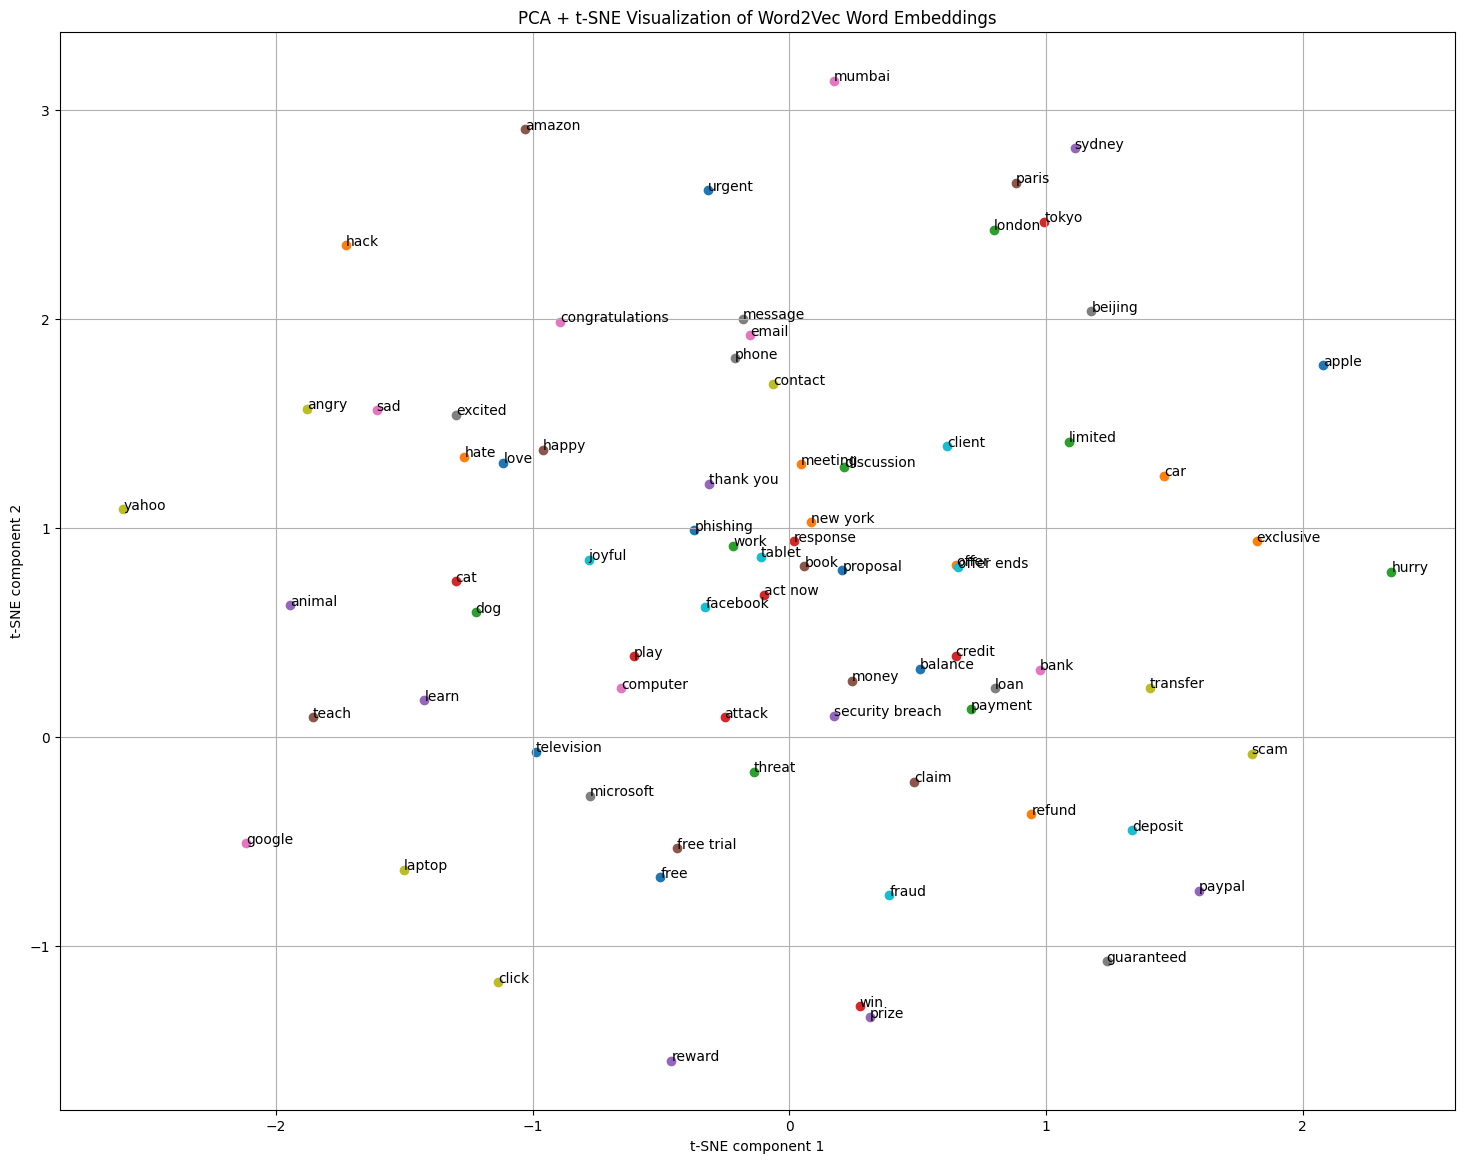

Plot saved as /Users/subhashree/Desktop/dsa4213/Features/evaluation/tsnefrompca_word_embeddings_batchA.png


In [12]:
# list of words to visualize
# chosen from various domains and clusters to assess the generalization ability of the model
words_to_visualize = [
    # Spam-related words
    "free", "offer", "limited", "win", "prize", "claim", "congratulations", "guaranteed",
    "click", "offer ends", "urgent", "exclusive", "hurry", "act now", "reward", "free trial",
    # Common Email words
    "email", "message", "contact", "client", "proposal", "meeting", "discussion", "response", "thank you",
    # Financial words
    "money", "bank", "loan", "transfer", "deposit", "balance", "refund", "payment", "credit",
    # Names and organizations
    "paypal", "amazon", "google", "microsoft", "yahoo", "facebook", "apple",
    # Locations
    "new york", "london", "tokyo", "sydney", "paris", "mumbai", "beijing",
    # Negative words (for scam detection)
    "scam", "fraud", "phishing", "hack", "threat", "attack", "security breach",
    # Objects and items
    "book", "computer", "phone", "laptop", "tablet", "television", "car", "dog", "cat", "animal",
    # General words
    "happy", "sad", "excited", "angry", "joyful", "love", "hate", "work", "play", "learn", "teach"
]

# fn to get full word embedding by averaging subword embeddings
def get_full_word_embedding(word, w2v_model, sp):
    subword_tokens = sp.encode_as_pieces(word)
    subword_embeddings = [w2v_model.wv[subword] for subword in subword_tokens if subword in w2v_model.wv]
    if subword_embeddings:
        return np.mean(subword_embeddings, axis=0)  # Average the embeddings
    else:
        return None

# get embeddings for the full words (averaging subword embeddings)
embeddings = [get_full_word_embedding(word, w2v_model, sp) for word in words_to_visualize]
embeddings = [embedding for embedding in embeddings if embedding is not None]  # Remove None values

# step 1: apply PCA to reduce dimensionality to 50 components
pca = PCA(n_components=50)
pca_result = pca.fit_transform(embeddings)
print(f"Explained variance by PCA components: {sum(pca.explained_variance_ratio_)}")

# step 2: apply t-SNE to reduce dimensions from PCA result to 2D
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(pca_result)

# step 3: visualize the t-SNE result 
plt.figure(figsize=(18, 14)) 
for i, word in enumerate(words_to_visualize):
    plt.scatter(tsne_result[i, 0], tsne_result[i, 1])
    plt.text(tsne_result[i, 0], tsne_result[i, 1], word, fontsize=10)

plt.title("PCA + t-SNE Visualization of Word2Vec Word Embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.grid(True)

# save the image to the current directory
file_path = os.path.join(os.getcwd(), 'tsnefrompca_word_embeddings_batchA.png')
plt.savefig(file_path)

# show the plot
plt.show()

print(f"Plot saved as {file_path}")

#### PCA Plot

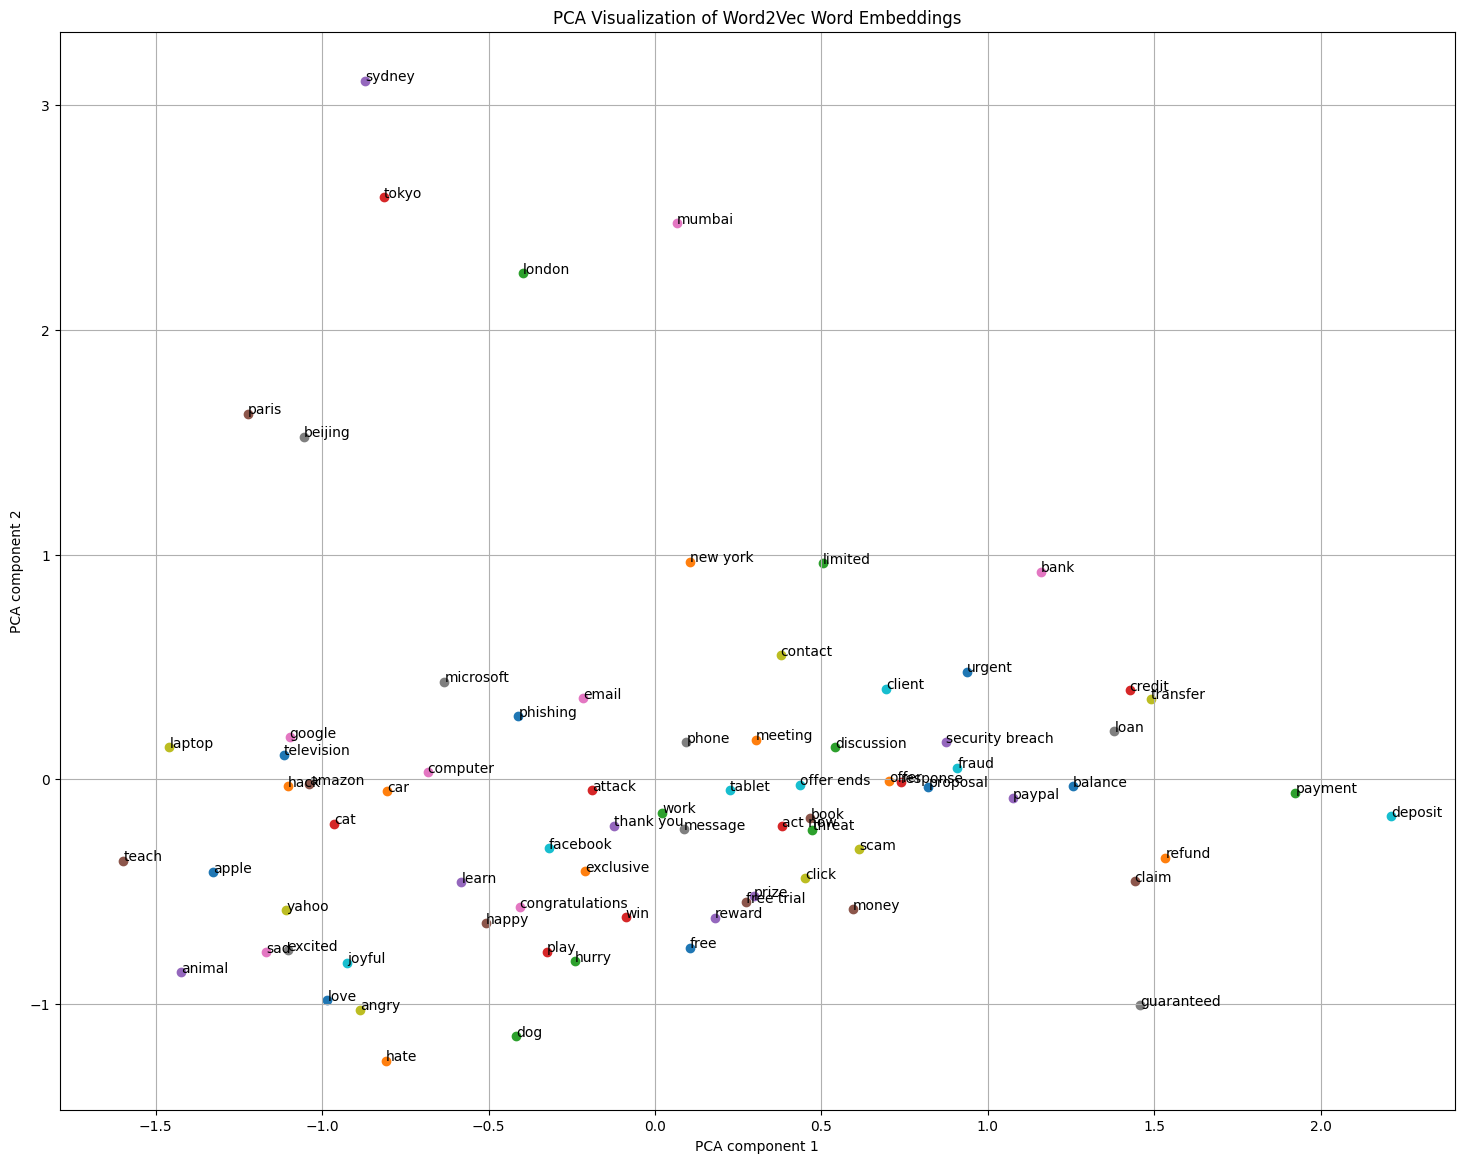

Plot saved as /Users/subhashree/Desktop/dsa4213/Features/evaluation/pca_word_embeddings_batchA.png


In [13]:
# list of words to visualize
words_to_visualize = [
    "free", "offer", "limited", "win", "prize", "claim", "congratulations", "guaranteed",
    "click", "offer ends", "urgent", "exclusive", "hurry", "act now", "reward", "free trial",
    "email", "message", "contact", "client", "proposal", "meeting", "discussion", "response", "thank you",
    "money", "bank", "loan", "transfer", "deposit", "balance", "refund", "payment", "credit",
    "paypal", "amazon", "google", "microsoft", "yahoo", "facebook", "apple",
    "new york", "london", "tokyo", "sydney", "paris", "mumbai", "beijing",
    "scam", "fraud", "phishing", "hack", "threat", "attack", "security breach",
    "book", "computer", "phone", "laptop", "tablet", "television", "car", "dog", "cat", "animal",
    "happy", "sad", "excited", "angry", "joyful", "love", "hate", "work", "play", "learn", "teach"
]

# fn to get the full word embedding by averaging subword embeddings
def get_full_word_embedding(word, w2v_model, sp):
    subword_tokens = sp.encode_as_pieces(word)
    subword_embeddings = [w2v_model.wv[subword] for subword in subword_tokens if subword in w2v_model.wv]
    if subword_embeddings:
        return np.mean(subword_embeddings, axis=0)
    else:
        return None

# get embeddings for the full words
embeddings = [get_full_word_embedding(word, w2v_model, sp) for word in words_to_visualize]
embeddings = [embedding for embedding in embeddings if embedding is not None]

# apply PCA: reduce dimensionality to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# plot PCA result
plt.figure(figsize=(18, 14))  # Increase figure size for better readability
for i, word in enumerate(words_to_visualize):
    plt.scatter(pca_result[i, 0], pca_result[i, 1])  # Use pca_result, not tsne_result
    plt.text(pca_result[i, 0], pca_result[i, 1], word, fontsize=10)

plt.title("PCA Visualization of Word2Vec Word Embeddings")
plt.xlabel("PCA component 1")
plt.ylabel("PCA component 2")
plt.grid(True)

# save the image to the current directory
file_path = os.path.join(os.getcwd(), 'pca_word_embeddings_batchA.png')
plt.savefig(file_path)

# show the plot
plt.show()

print(f"Plot saved as {file_path}")

#### t-SNE Plot

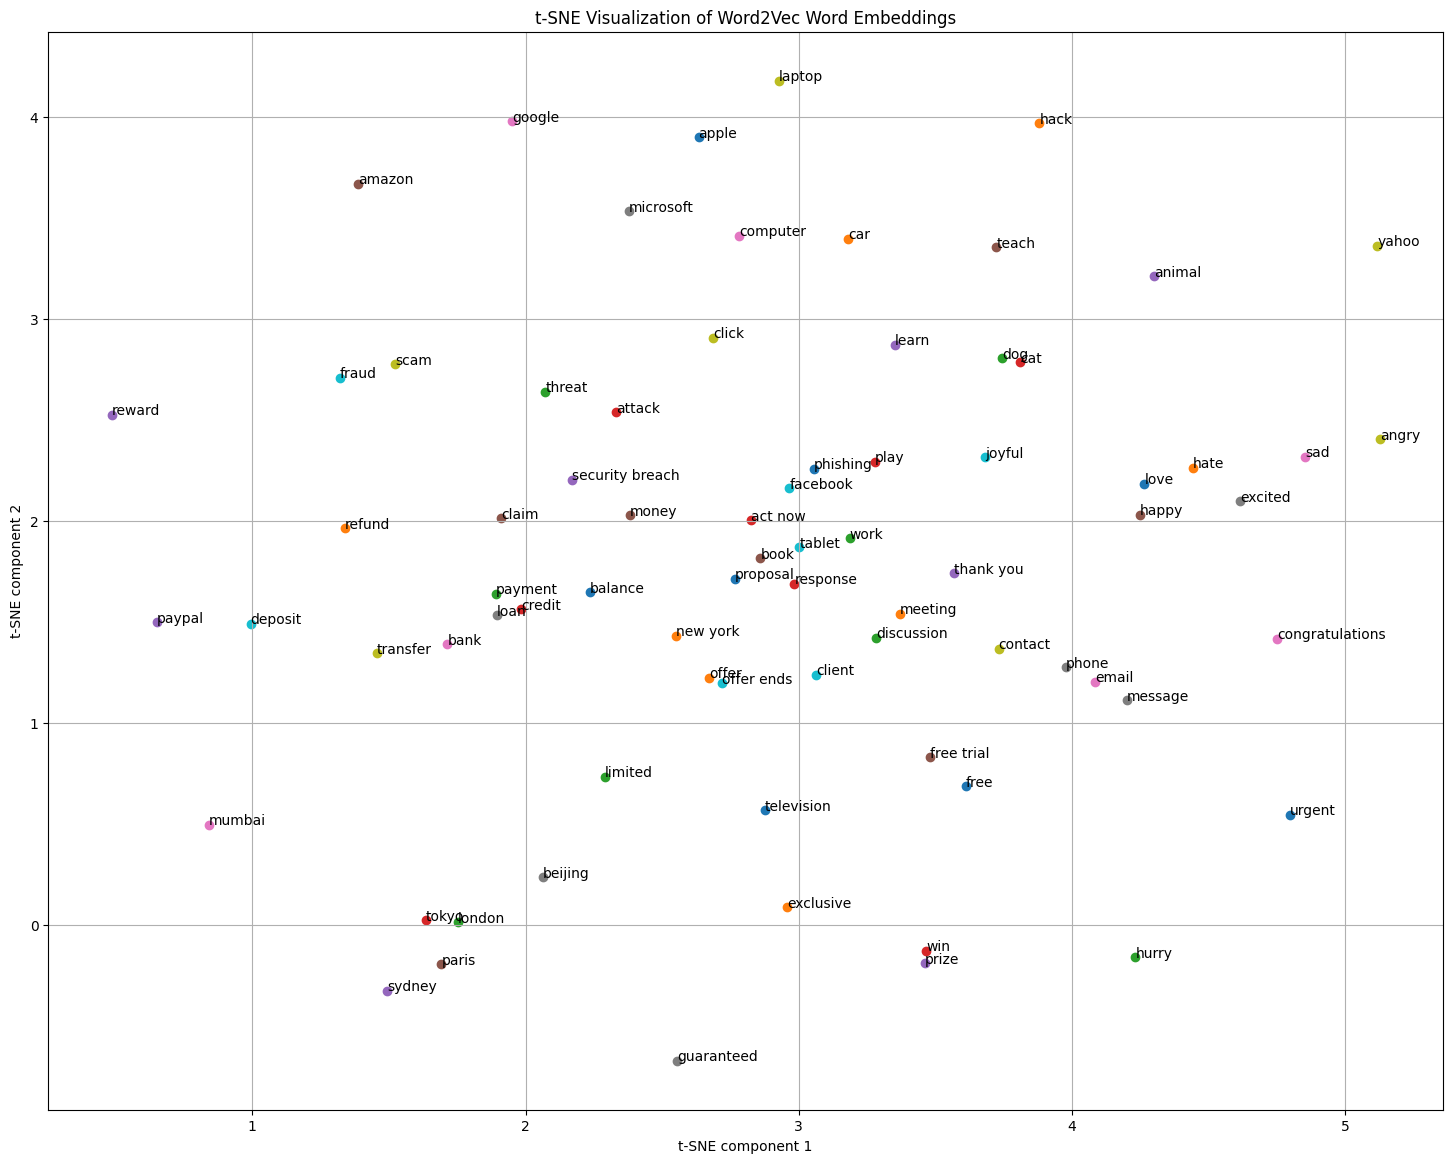

Plot saved as /Users/subhashree/Desktop/dsa4213/Features/evaluation/tsne_word_embeddings_batchA.png


In [14]:
# convert list of embeddings to a NumPy array
embeddings = np.array(embeddings)

# apply t-SNE: reduce dimensions directly to 2D from original embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(embeddings)

# plot t-SNE result
plt.figure(figsize=(18, 14)) 
for i, word in enumerate(words_to_visualize):
    plt.scatter(tsne_result[i, 0], tsne_result[i, 1])
    plt.text(tsne_result[i, 0], tsne_result[i, 1], word, fontsize=10)

plt.title("t-SNE Visualization of Word2Vec Word Embeddings")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.grid(True)

# save the image to the current directory
file_path = os.path.join(os.getcwd(), 'tsne_word_embeddings_batchA.png')
plt.savefig(file_path)

# show the plot
plt.show()

print(f"Plot saved as {file_path}")

### Evaluation 3: Cosine similarity between word pairs

In [15]:
# list of word pairs to compare 
# first 5 is domain related, next 5 are general vocabulary, to show difference between how well the model had learned the word embeddings for both types of text
word_pairs = [
    ("click", "link"),
    ("win", "prize"),
    ("payment", "refund"),
    ("email", "message"),
    ("offer", "discount"),
    ("happy", "joyful"),
    ("dog", "cat"),
    ("car", "vehicle"),
    ("mountain", "hill"),
    ("apple", "banana")
]

# fn to compute cosine similarity between two words (based on subword embeddings)
def compute_cosine_similarity(word1, word2, sp, w2v_model):
    # Tokenize words to subwords
    subwords_1 = sp.encode_as_pieces(word1)
    subwords_2 = sp.encode_as_pieces(word2)
    
    # get embeddings for subwords (avg them)
    embedding_1 = np.mean([w2v_model.wv[subword] for subword in subwords_1], axis=0)
    embedding_2 = np.mean([w2v_model.wv[subword] for subword in subwords_2], axis=0)
    
    # compute cosine similarity
    similarity = cosine_similarity([embedding_1], [embedding_2])
    return similarity[0][0]

# store results in list
similarity_results = []

# loop thru word pairs and compute similarity
for word1, word2 in word_pairs:
    similarity = compute_cosine_similarity(word1, word2, sp, w2v_model)
    similarity_results.append([word1, word2, similarity])

# convert results into Pandas df
similarity_df = pd.DataFrame(similarity_results, columns=["Word 1", "Word 2", "Cosine Similarity"])

# display table
similarity_df

,Word 1,Word 2,Cosine Similarity
0,click,link,0.584135
1,win,prize,0.440995
2,payment,refund,0.412711
3,email,message,0.454378
4,offer,discount,0.377566
5,happy,joyful,0.359121
6,dog,cat,0.284248
7,car,vehicle,0.359549
8,mountain,hill,0.224200
9,apple,banana,0.248496
